In [1]:
import numpy as np
import re
import string

with open('D:/positive.txt', 'rt', encoding='utf-8-sig') as infile:
    pos_tweets = infile.readlines()
with open('D:/negative.txt', 'rt', encoding='utf-8-sig') as infile:
    neg_tweets = infile.readlines()
    
all_text=pos_tweets+neg_tweets

In [2]:
#using 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_tweets)), np.zeros(len(neg_tweets))))

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('kazakh')
stop_words.extend(['да', 'де', 'та', 'те', 'бен', 'пен', 'ма', 'ме', 'па', 'пе', 'ба', 'бе', 'әрі','және','бізде','сізде','ода','біздерде','сіздерде','оларда','менің','сенің','оның','оларды','мені','сені','өзіңіз','мұны','бұны'])

In [4]:
#Text preprocessing
def cleanText(text):
    text = " ".join(re.sub("([@][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",text).split()) 
    text = " ".join(filter(lambda x:x[0]!='#', text.split())) 
    emoticons=[]
    emoticons=re.findall('(?:\)|\(|:|;|=)(?:-)?(?:\)|\(|D|P|/)', text)
    text = text.lower().replace('\n','')
    text = nltk.word_tokenize(text)
    text = [j.replace("rt", "") for j in  text]
    text = [item for item in text if item.isalpha()]
    text = [j for j in text if ( j not in stop_words )]
    text = text + emoticons
    return text

In [6]:
#cleaning
all_text=[cleanText(t) for t in all_text]

In [5]:
#stemmer
class Porter:
    PERFECTIVEGROUND =  re.compile(u"((мін|мын|пын|ңіз))$")
    REFLEXIVE = re.compile(u"(с[яь])$")
    ADJECTIVE = re.compile(u"(лы|лі|ды|ты|ті|сыз|сіз|ғы|гі|қы|кі|шыл|шіл|шаң|шең|дай|дей|тай|тей|қой|кер|паз|гер|и|ы|і)$")
    PARTICIPLE = re.compile(u"(ған|ген|қан|кен|атын|етін|ар|ер|р|с|мақ|мек|пақ|пек)$")
    VERB = re.compile(u"(у|ю|ма|ме|па|пе|шы|ші|лау|леу|ды|ді|ады|ған|қан|дым|дың|дық|ты|ті|тым|тың|тық|амыз|асын|сын|сін|мын|амын|асын|сын|мыз|ямыз|яды|ясын|ғыз|гіз|қыз|кіз|ыпты|епті)$")
    NOUN = re.compile(u"(ны|ні|ты|ті|ды|ы|і|м|мыз|міз|ң|ңыз|ңіз|сы|сі|ым|ім|ымыз|іміз|ың|ің|ыңыз|іңіз|ның|нің|дың|дің|ға|ге|қа|ке|да|де|та|те|дан|ден|тан|тен|мен|пен)$")
    RVRE = re.compile(u"^(.*?[аәеоөұүыіуиэюя])(.*)$")
    DERIVATIONAL = re.compile(u".*[^аәеоөұүыіуиэюя]+[аәеоөұүыіуиэюя].*(лық|лік|дық|дік|тық|тік|шық|шік|шы|ші|ша|ше|хана|стан|кеш|ма|ме|ба|бе|па|пе|ым|ім|м|қы|кі|ғы|гі|ыс|іс|с|ық|ік|қ|к|іш|ыш|ш|уыш|уіш)?$")
    DER = re.compile(u"(лық|лік|дық|дік|тық|тік|шық|шік|шы|ші|ша|ше|хана|стан|кеш|ма|ме|ба|бе|па|пе|ым|ім|м|қы|кі|ғы|гі|ыс|іс|с|ық|ік|қ|к|іш|ыш|ш|уыш|уіш)?$")
    I = re.compile(u"(лар|лер|дар|дер|тар|тер)$")

    def stem(word):
        word = word.lower()
        word = word.replace(u'ё', u'е')
        m = re.match(Porter.RVRE, word)
        if m and m.groups():
            pre = m.group(1)
            rv = m.group(2)
            temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
            if temp == rv:
                rv = Porter.REFLEXIVE.sub('', rv, 1)
                temp = Porter.ADJECTIVE.sub('', rv, 1)
                if temp != rv:
                    rv = temp
                    rv = Porter.PARTICIPLE.sub('', rv, 1)
                else:
                    temp = Porter.VERB.sub('', rv, 1)
                    if temp == rv:
                        rv = Porter.NOUN.sub('', rv, 1)
                    else:
                        rv = temp
            else:
                rv = temp

            rv = Porter.I.sub('', rv, 1)
            if re.match(Porter.DERIVATIONAL, rv):
                rv = Porter.DER.sub('', rv, 1)
            word = pre+rv
        return word
    stem=staticmethod(stem)

In [7]:
#stemming
for i in range(len(all_text)):
    all_text[i] = [Porter.stem(word) for word in all_text[i]]

In [8]:
#Initializing word2vec model and building vocab
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import scale

w2v_model = Word2Vec(size=300, window=5, workers=5, sg=1, min_count=10, negative=5)
w2v_model.build_vocab(all_text)


In [9]:
#Training the model over reviews
w2v_model.train(all_text, total_examples= w2v_model.corpus_count, epochs= w2v_model.epochs)

(5447663, 7356220)

In [10]:
#Building word vector for training set by using the average value of all word vectors in the tweet, then scale
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [11]:
vecs = np.concatenate([buildWordVector(z, 300) for z in all_text])
vecs = scale(vecs)

In [16]:
vecs

array([[-0.29658659, -0.3552238 , -0.22400903, ..., -0.36507709,
        -0.47873914, -0.88831794],
       [ 0.26898022,  0.56886972,  0.07129317, ..., -1.01504131,
         1.80181514, -0.65046773],
       [-0.43659713,  0.11930551, -1.40070174, ...,  0.92566836,
         0.97932031,  1.09993288],
       ...,
       [-0.96634425, -0.35679633,  1.32332502, ..., -0.42133185,
        -0.04190503,  0.27050108],
       [ 0.35564628, -0.61986625, -0.742789  , ..., -0.43713342,
         0.50324189,  1.33863666],
       [-0.42305415,  0.58670898,  0.84579754, ..., -0.57449668,
        -0.36708367, -0.67763467]])

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vecs, y, test_size=0.05, random_state=42)

In [16]:
#searching for optimal value of C parameter
cv=StratifiedKFold(n_splits=4)
c_range = [0.001, 0.01, 0.1, 1, 10]
c_scoreslr = []
for c in c_range:
    lr = LogisticRegression(C=c, solver='saga', max_iter=10000, random_state=0, n_jobs=-1)
    scores = cross_val_score(lr, X_test, y_test, cv=cv, scoring='accuracy', n_jobs=-1)
    c_scoreslr.append(scores.mean())
print(c_scoreslr)

[0.8319233116203384, 0.8375582306803129, 0.8448661500528355, 0.8469796942982304, 0.8485647594620205]


In [14]:
#searching for optimal value of C parameter
cv=StratifiedKFold(n_splits=10)
c_range = [0.001, 0.01, 0.1, 1, 10]
c_scoreslr = []
for c in c_range:
    lr = LogisticRegression(C=c, solver='saga', max_iter=10000, random_state=0, n_jobs=-1)
    scores = cross_val_score(lr, vecs, y, cv=cv, scoring='accuracy', n_jobs=-1)
    c_scoreslr.append(scores.mean())
print(c_scoreslr)

[0.8472541671710332, 0.850758370340551, 0.8518281247644109, 0.8512514323327132, 0.851097350678188]


In [17]:
#searching for best kernel
kernel = ['poly', 'rbf', 'sigmoid','linear']
k_scores = []
for k in kernel:
    svm = SVC(kernel=k, random_state=0)
    scores = cross_val_score(svm, X_test, y_test, cv=cv, scoring='accuracy', n_jobs=-1)
    k_scores.append(scores.mean())
print(k_scores)

[0.8354453065699586, 0.8460107643040349, 0.7862289712207731, 0.8499732101662458]


In [18]:
#searching for optimal value of C parameter for SVM
c_scoressvm = []
for c in c_range:
    svm = LinearSVC(C=c, random_state=0, dual=False)
    scores = cross_val_score(svm, X_test, y_test, cv=cv, scoring='accuracy', n_jobs=-1)
    c_scoressvm.append(scores.mean())
print(c_scoressvm)

[0.8390551436480809, 0.8467153617371719, 0.8490927114288408, 0.8475961705420973, 0.8457476099995536]


In [19]:
#Evaluating classifiers
models = {"NB": GaussianNB(),
          "SVM": LinearSVC(C=0.1, random_state=0, max_iter=10000),
          "LR": LogisticRegression(C=1, solver='saga', random_state=0, max_iter=10000)}
scoring = ['accuracy', 'precision', 'recall', 'f1']
sc = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
cv=StratifiedKFold(n_splits=10)
for model in models:
    scores = cross_validate(models[model], vecs, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(model)
    for i in sc:
        print(i,": ",scores[i].mean())

NB
test_accuracy :  0.7987453848779698
test_precision :  0.7772074224839431
test_recall :  0.8453058110519172
test_f1 :  0.80980036885958
SVM
test_accuracy :  0.855389588102527
test_precision :  0.8520941698073761
test_recall :  0.8647634284402917
test_f1 :  0.8583736246944023
LR
test_accuracy :  0.8539984636253675
test_precision :  0.8509313483979989
test_recall :  0.8631216942602336
test_f1 :  0.8569754193669482


In [22]:
models = {"NB": GaussianNB(),
          "SVM": LinearSVC(C=0.1, random_state=0, dual=False),
          "LR": LogisticRegression(C=1, solver='saga', random_state=0, max_iter=10000)}
#Calculating confusion matrix
def confusionMatrix(model):
    conf_matrix_list_of_arrays = []
    cv=StratifiedKFold(n_splits=10)
    for i, (train, test) in enumerate(cv.split(vecs, y)):
        X_train, X_test = vecs[train], vecs[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        conf_matrix = confusion_matrix(y_test, model.predict(X_test))
        conf_matrix_list_of_arrays.append(conf_matrix)
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
    return mean_of_conf_matrix_arrays

for model in models:
    print(model)
    print(confusionMatrix(models[model]))

NB
[[8412.4 2790.7]
 [1780.9 9731.5]]
SVM
[[9473.4 1729.7]
 [1553.7 9958.7]]
LR
[[9462.4 1740.7]
 [1575.8 9936.6]]


NB


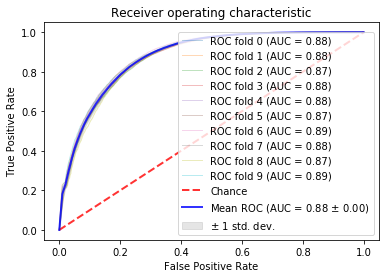

SVM


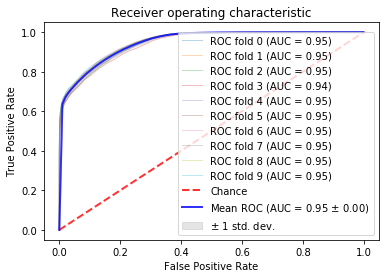

LR


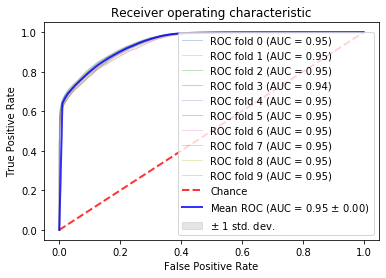

In [23]:
#Plotting ROC curve
from numpy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

def plotROC(classifier):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(vecs, y)):
        classifier.fit(vecs[train], y[train])
        viz = plot_roc_curve(classifier, vecs[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

for model in models:
    print(model)
    plotROC(models[model])

In [18]:
#determining the tonality of reviews on news
with open('D:/news.txt', 'rt', encoding='utf-8-sig') as infile:
    reviews = infile.readlines()
reviews=cleanText(reviews)
for i in range(len(reviews)):
    reviews[i] = [Porter.stem(word) for word in reviews[i]]
review_vecs = np.concatenate([buildWordVector(z, 300) for z in reviews])
review_vecs = scale(review_vecs)

In [24]:
svm = LinearSVC(C=0.1, random_state=0, max_iter=10000)
svm.fit(vecs, y)
predicted_svm = svm.predict(review_vecs)
print(np.mean(predicted_svm))

0.5


In [21]:
lr = LogisticRegression(C=1, solver='saga', random_state=0, max_iter=10000)
lr.fit(vecs, y)
predicted_lr = lr.predict(review_vecs)
print(np.mean(predicted_lr))

0.5


In [23]:
nb = GaussianNB()
nb.fit(vecs, y)
predicted_nb = nb.predict(review_vecs)
print(np.mean(predicted_nb))

0.3333333333333333


In [26]:
print(predicted_svm, predicted_lr, predicted_nb)

[0. 1. 0. 1. 1. 0.] [0. 1. 0. 1. 1. 0.] [1. 0. 1. 0. 0. 0.]
